# Tutorial 03: Counterfactual analysi & Rewrite rules

For scalable counterfactual analysis, Errudite uses rules to rewrite all relevant instances within a group – similar to search and replace but with the flexibility and power of the Errudite DSL. 

Just like `DatasetReader`, `Predictor` and `PrimFunc`, `Rewrite` allows extension through `register`. There are two large types of rewrite rules: defaults (see the documentation), and those implemented in the syntax of `rewrite(target, from -> to)`: 

> Target indicates the part of the instance that should be rewritten by replacing from with to. Depending on whether or not you want to use linguistic features.

We will introduce the latter here.

### Setup

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

def import_sys():
    import sys
    sys.path.append('..')
import_sys()

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

import errudite
print(errudite)

<module 'errudite' from '/Users/tongshuangwu/sourcetree/errudite/errudite/__init__.py'>


In [3]:
# set the dataset reader
from errudite.io import DatasetReader

cache_folder_path = "./data/snli_tutorial_caches/"
reader = DatasetReader.by_name("snli")(
    cache_folder_path=cache_folder_path)
instances = reader.load_preprocessed()

INFO:errudite.utils.file_utils:Errudite cache folder selected: ./data/snli_tutorial_caches/
INFO:errudite.io.dataset_reader:Loaded 100 objects to ./data/snli_tutorial_caches/instances.pkl.
INFO:errudite.io.dataset_reader:Loaded 100 objects to ./data/snli_tutorial_caches/evaluations/decompose_att.pkl.


## Create the Pattern Replacing Rule

As mentioned before, a typical customized rewrite rule  rewrites the `target_cmd` part of an instance by replacing `from_cmd` with `to_cmd`. The name/rid of the rule is: `{from_cmd} -> {to_cmd}` ([documentation](https://errudite.readthedocs.io/en/latest/api/errudite.rewrites.defines.html)).

Both `from_cmd` and `to_cmd` can include linguistic annotations, in ALL CAPS. For example, to create a rule that add "not" before an adjective in the hypothesis, we can input `from_cmd="ADJ"`, and `to_cmd="not ADJ"`.

In [4]:
from errudite.rewrites import Rewrite
rewrite = Rewrite.create_with_cmd(
    from_cmd='ADJ', 
    to_cmd='not ADJ', 
    target_cmd='hypothesis'
)

INFO:errudite.build_blocks.wrapper:Parsed: hypothesis


<class 'errudite.rewrites.replace_pattern.ReplacePattern'>


In [5]:
rewrite.pattern

PatternMeta(before=[{'POS': 'ADJ'}], after=({'LOWER': 'not'}, {'POS': 'ADJ'}))

### Run the rewrite and save the new instance

Once a rewrite is created, you could apply the rewrite to all instances at once, and formalize the rewritten instances in a way similar to the preprocessing steps. Let's first load a predictor:

In [6]:
# ---------
# load a predictor
from errudite.predictors import Predictor
model_online_path = "https://s3-us-west-2.amazonaws.com/allennlp/models/decomposable-attention-elmo-2018.02.19.tar.gz"
predictor = Predictor.by_name("nli_decompose_att")(
    name='decompose_att', 
    description='Pretrained model from Allennlp, for the decomposable attention model',
    model_online_path=model_online_path)

INFO:pytorch_pretrained_bert.modeling:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:pytorch_transformers.modeling_bert:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:pytorch_transformers.modeling_xlnet:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.models.archival:loading archive file https://s3-us-west-2.amazonaws.com/allennlp/models/decomposable-attention-elm

#### Create a group of instances to be rewritten.

The rewrite could be applied to all instances, or just a group of instances that you are interested in. In our previous tutorial, we've seen that the model correctly predict all instances that have high `overlap(premise, hypothesis)`. Is the model smart enough to sense the change of hypothesis direction, when we add negation to it? We create a group of instances with high overlap:

In [7]:
from errudite.builts import Group
group = Group.create(
    name="high_overlap",
    description="The premise and the hypothsis have high textual overlap.",
    cmd="overlap(premise, hypothesis) > 0.5",
)

INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(overlap):[ArgOp:premise, ArgOp:hypothesis]+[], 0.5]
INFO:errudite.builts.group:Created group: high_overlap


Then, rewrite all the instances in the group:

In [8]:
from errudite.targets.instance import Instance
from errudite.targets.target import Target
from tqdm import tqdm

for key in tqdm(group.get_instances()):
    """
    This function returns a named tuple, with rid and the 
    rewritten text of the instance intended target. 
    If the instance cannot be rewritten, return None.
    """
    instance = Instance.get(key)
    rewritten_output = rewrite.rewrite_one_instance(instance)
    if not rewritten_output:
        continue
    entries = {}
    # compute the vid automatically
    vid = len(Instance.qid_hash[instance.qid])
    # init the instance 
    rewritten_instance = Instance(
        qid=instance.qid, vid=vid, rid=rewrite.rid)
    for e in instance.entries:
        if e in rewrite.target_cmd:
            # automatically create a new Target for the 
            # rewritten part.
            entry = Target(
                qid=instance.qid, 
                text=rewritten_output.text, 
                vid=vid, 
                metas=instance.get_entry(e).metas)
        else:
            # Otherwise, use the original target
            entry = instance.get_entry(e)
        # save all the entries
        rewritten_instance.set_entries(**{e: entry})
    # run the prediction
    prediction = Predictor.by_name("nli_task_class").model_predict(
        predictor, 
        rewritten_instance.get_entry('premise'), 
        rewritten_instance.get_entry('hypothesis'), 
        rewritten_instance.get_entry('groundtruth'))
    # save the prediction
    rewritten_instance.set_entries(predictions= [ prediction ])
    # set the rewritten key into the rewrite
    rewrite.add_instance(rewritten_instance.key())
    # save into the Instance hashes
    Instance.save(rewritten_instance)

100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


Take a look at the rewritten instances that have changed predictions:

In [9]:
ie = list(Instance.instance_hash_rewritten.values())[1]
rewrite.show_changed_instances(ouput_directions=[-1]) # -1 means prediction changed to incorrect

Flipped direction: -1
---------------------------------
[Instance] [InstanceKey(qid='3497317981.jpg#2r1e', vid=0)]
[hypothesis]	The man wearing the black shirt plays a game of golf.
[premise]	A man in a black shirt is playing golf outside.
[groundtruth]	entailment	groundtruth	{}
[predictions]	entailment	decompose_att	{'accuracy': 1.0, 'confidence': 0.9510674476623535}

[Instance] [InstanceKey(qid='3497317981.jpg#2r1e', vid=1)]
[hypothesis]	The man wearing the not black shirt plays a game of golf.
[premise]	A man in a black shirt is playing golf outside.
[groundtruth]	entailment	groundtruth	{}
[predictions]	contradiction	decompose_att	{'accuracy': 0.0, 'confidence': 0.8892192244529724}

[Instance] [InstanceKey(qid='3168293517.jpg#2r1e', vid=0)]
[hypothesis]	Boy dressed in blue holds a toy.
[premise]	A little boy in a blue shirt holding a toy.
[groundtruth]	entailment	groundtruth	{}
[predictions]	entailment	decompose_att	{'accuracy': 1.0, 'confidence': 0.9717243909835815}

[Instance] [In

#### Visualize rewritten instance changing status:

The visualization for a rewrite rule is one-bar histogram that displays the count of instances rewritten, and the proportion of "flip_to_correct", "flip_to_incorrect", "unflip". Because of the flipping proportion, this historgram is different for each different model. Here, we've only rewritten four instances, and two of them have changed predictions -- to incorrect.

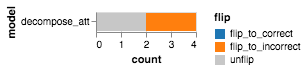

In [10]:
rewrite.visualize_models(models=["decompose_att"])

We could also print the instance correctness for the given filtering instance in numbers:

In [11]:
from errudite.rewrites import Rewrite
Rewrite.eval_stats(rewrite,qids=None)

{'counts': {'rewritten': 4,
  'prediction_changed': 2,
  'flips': {'flip_to_correct': 0, 'flip_to_incorrect': 2, 'unflip': 2}},
 'stats': {'coverage': 0.04, 'changed_coverage': 0.02, 'changed_rate': 0.5}}

## Rewrites defined with customized functions

Similar to attributes and groups, rewrites can be defined with functions ([documentation]()): 

In [12]:
def add_you_know_what(instance):
    return "You know what? " + instance.premise.doc.text
rewrite_no_change = Rewrite.create_with_func(
    rewrite_func=add_you_know_what,
    target_cmd='premise'
)

INFO:errudite.build_blocks.wrapper:Parsed: premise


In [13]:
import inspect
inspect.getsource(rewrite_no_change._rewrite_func)

'def add_you_know_what(instance):\n    return "You know what? " + instance.premise.doc.text\n'

# Save & reload

The saving and reloading of rewrite rules are similar to those of attributes or groups.

In [14]:
Rewrite.export_to_file (file_name="save_rewrite.json")

INFO:errudite.utils.store:Done saving to ./data/snli_tutorial_caches/analysis/save_rewrite.json


True

In [15]:
Rewrite.import_from_file('save_rewrite.json')

INFO:errudite.build_blocks.wrapper:Parsed: hypothesis
INFO:errudite.build_blocks.wrapper:Parsed: premise


{'ADJ -> not ADJ': [ReplacePattern] ADJ -> not ADJ, 'add_you_know_what': 
 [rewrite]
 	[rid]	add_you_know_what
 	[des]	Customized rewrite function
 	[target_cmd]	premise}